# Exploitation

This section implements pure exploitation process where the next infill point is obtained by **minimizing the surrogate prediction**.  Below code imports required packages, defines modified branin function, and creates plotting data:

In [1]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note that the problem class is defined to use the surrogate model prediction instead of the actual function.

In [2]:
# Problem class
class Surrogate(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs the exploitation process. The maximum number of iterations is set to 15 and a convergence criterion is defined based on the change in true function value for infill points between two consecutive iterations.

In [3]:
sampler = LHS(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 15
tol = 1e-3
error = 1
criteria = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < error:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    print(sm.optimal_theta)

    # Find the minimum of surrogate model
    result = minimize(Surrogate(sm), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))
    
    if itr == 0:
        prev = y_infill
    else:
        error = np.abs(y_infill - prev)/np.abs(y_infill)
        prev = result.F
        criteria.append(error)
    
        print("Error: {}".format(error))

    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number


Iteration 1
[1.59752145e+01 1.07349020e-04]
f*: [105.66870658]
x*: [-2.48709204e+00  9.34432468e-13]

Iteration 2
[4.20184045e-04 2.38300933e+01]
Error: [12.86758374]
f*: [7.61983548]
x*: [-2.0647228   6.30190892]

Iteration 3
[3.27845988e-04 8.37475509e+00]
Error: [0.01603451]
f*: [7.7459277]
x*: [-2.06845249  6.28499503]

Iteration 4
[0.01008008 7.36871833]
Error: [0.88035853]
f*: [63.63637219]
x*: [10.          6.42249335]

Iteration 5
[0.92319499 0.34511898]
Error: [0.27459271]
f*: [-5.20688161]
x*: [-2.58297053  8.55404406]

Iteration 6
[0.3928354  0.12511014]
Error: [0.94338264]
f*: [7.87567766]
x*: [-5.         12.69827073]

Iteration 7
[0.70096764 0.33378053]
Error: [2.00621006]
f*: [-9.52227896]
x*: [-3.37676721 10.25901365]

Iteration 8
[0.56594805 0.26322217]
Error: [0.03969432]
f*: [-10.65219337]
x*: [-3.23750131 10.24984632]

Iteration 9
[0.95710677 0.08043282]
Error: [0.41571901]
f*: [-16.41349028]
x*: [-3.66681355 14.05083477]

Iteration 10
[0.81649741 0.07208956]
Error

Below block of code plots the convergence of the exploitation process and infill points.

Text(0.5, 1.0, 'Modified Branin function')

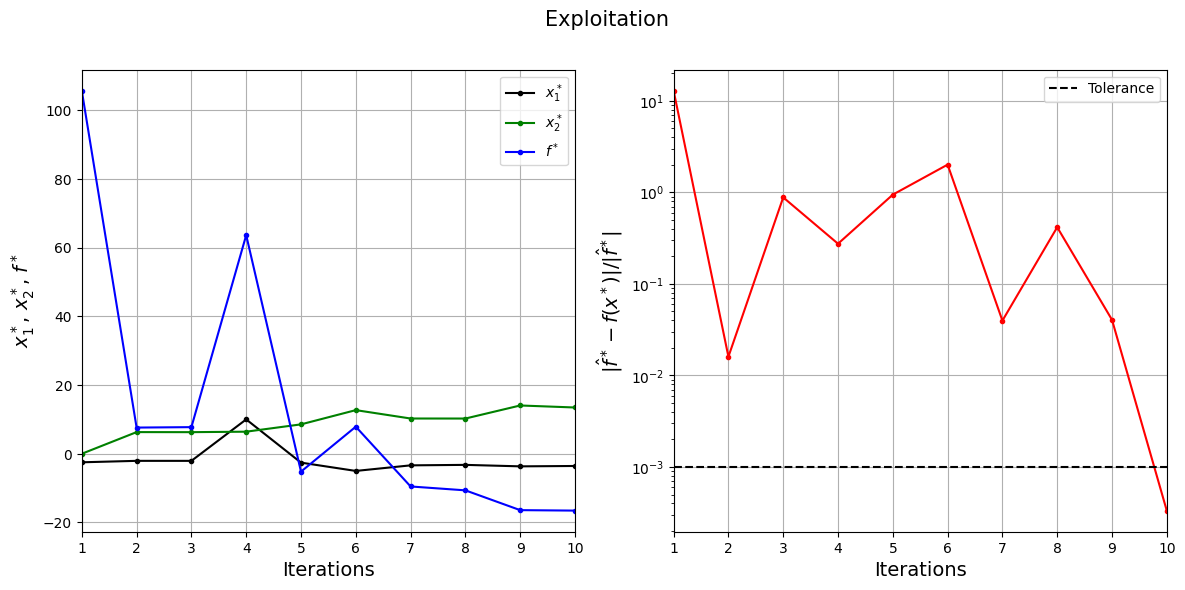

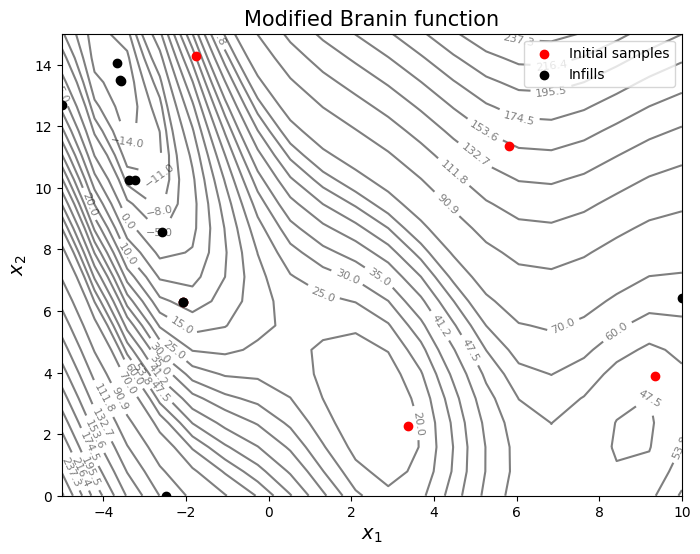

In [4]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ytrain[num_train:], c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("$x_1^*$, $x_2^*$, $f^*$", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr-1)
ax[0].grid()

ax[1].plot(np.arange(itr-1) + 1, criteria, c="red", marker=".")
ax[1].plot(np.arange(itr), [tol]*(itr), c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel(r"$| \hat{f}^* - f(x^*) | / | \hat{f}^* |$", fontsize=14)
ax[1].set_xlim(left=1, right=itr-1)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Exploitation".format(itr), fontsize=15)

####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.legend()
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Modified Branin function", fontsize=15)

Notice that process stopped before reaching maximum number of infills since the convergence criteria was met. Most of the points are added close to the optimum which demonstrates exploitation only and no exploration. This is useful when optimization of the underlying function is the only goal. This process will not generate a globally accurate surrogate.

> __*NOTE*__: Due to randomness in differential evolution, results may vary slightly between runs. So, it is recommend to run the code multiple times to see average behavior.